In [85]:
from ast import literal_eval

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch.nn.utils.parametrize as parametrize
from matrepr import mdisplay
from torch import linalg

from koopmann import aesthetics
from koopmann.data import (
    DatasetConfig,
    create_data_loader,
    get_dataset_class,
)
from koopmann.models import MLP, ExponentialKoopmanAutencoder
from koopmann.models.layers import LinearLayer
from koopmann.models.utils import (
    pad_act,
    parse_safetensors_metadata,
)
from koopmann.utils import compute_model_accuracy
from koopmann.visualization import plot_decision_boundary, plot_koopman_decision_boundary

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
model_name = "lotusroot_model"
scale_idx = "1"


In [87]:
model_file_path = f"/home/nsa325/work/koopmann/model_saves/{model_name}.safetensors"


In [88]:
metadata = parse_safetensors_metadata(file_path=model_file_path)
dataset_config = DatasetConfig(
    dataset_name=metadata["dataset"],
    num_samples=5_000,
    split="test",
    seed=21,
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config)
dataloader = create_data_loader(dataset, batch_size=1024)

In [89]:
model, _ = MLP.load_model(model_file_path)
model.eval()
model.hook_model()
print(f"Original Model Testing Accuracy: {compute_model_accuracy(model.to('cpu'), dataset)}")


Original Model Testing Accuracy: 0.9602000117301941


In [95]:
list_k = [25, 100, 500]
dim = "20"

Little K: 25
Little K: 100
Little K: 500


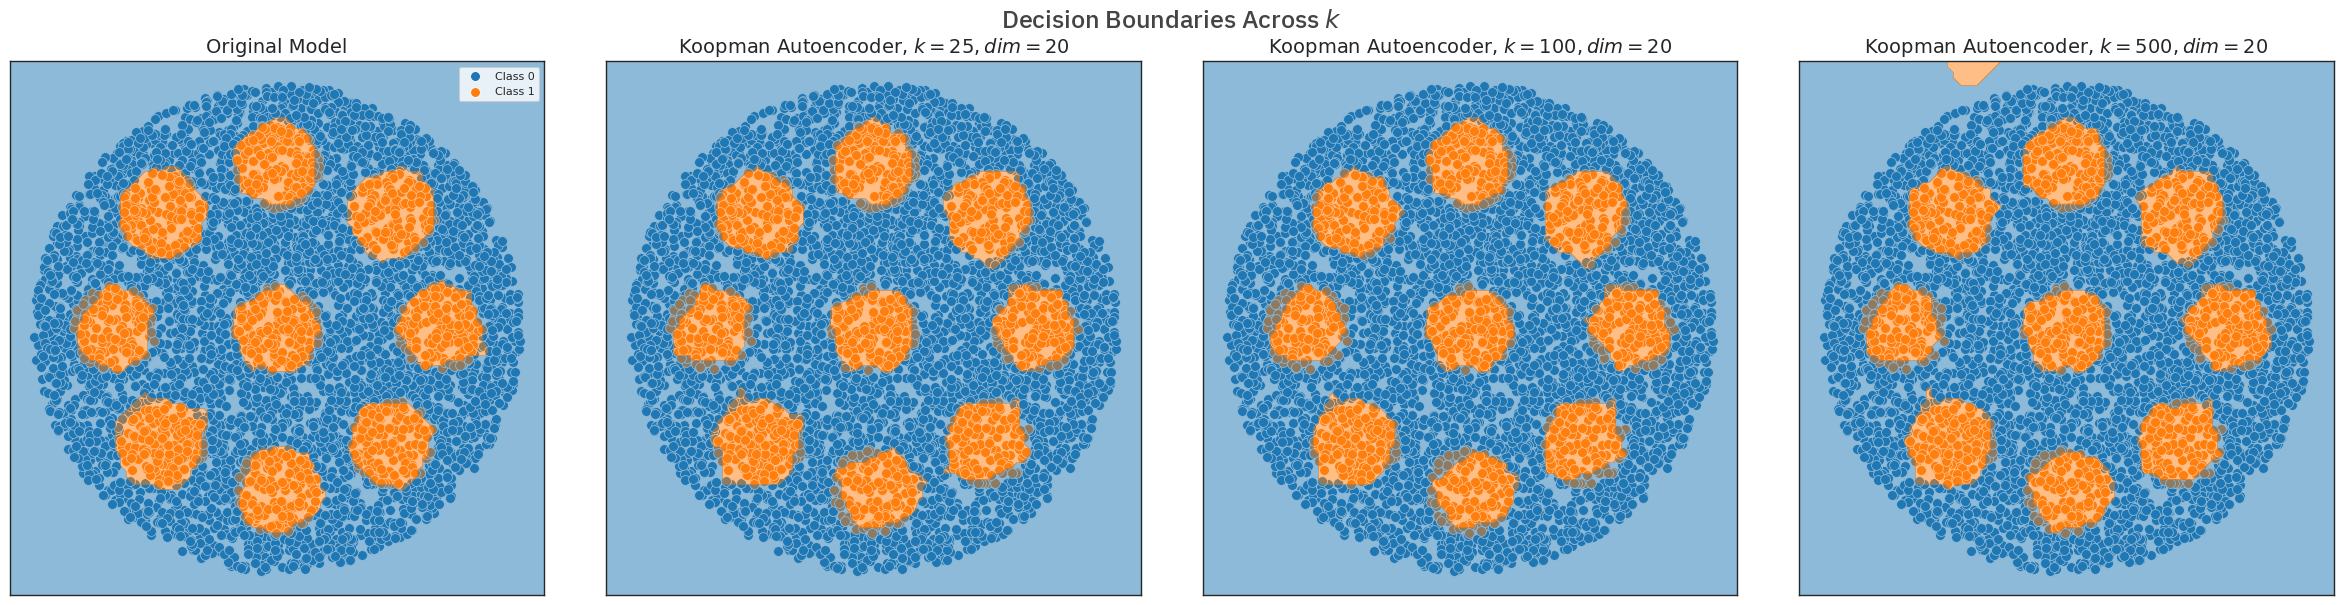

In [96]:
fig, axs = plt.subplots(1, len(list_k) + 1, figsize=((len(list_k) + 1) * 6, 6))  # 3 subplots

plot_decision_boundary(
    model,
    model.state_dict(),
    dataset.features,
    dataset.labels.squeeze(),
    labels=[0, 1, 2],
    ax=axs[0],  # Pass the current subplot axis
)
axs[0].set_title("Original Model", fontsize=14)

for i, k in enumerate(list_k):
    i = i + 1

    # ae_file_path = f"/home/nsa325/work/koopmann/model_saves/scaling/k_{k}_dim_{dim}_loc_{scale_idx}_autoencoder_{model_name}.safetensors"
    ae_file_path = f"/scratch/nsa325/koopmann/k_{k}_dim_{dim}_loc_{scale_idx}_autoencoder_{model_name}.safetensors"

    # autoencoder, metadata = Autoencoder.load_model(ae_file_path)
    autoencoder, metadata = ExponentialKoopmanAutencoder.load_model(ae_file_path)
    autoencoder.eval()

    k = literal_eval(metadata["num_scaled"])
    print(f"Little K: {k}")

    plot_koopman_decision_boundary(
        model=model,
        final_state_dict=model.state_dict(),
        autoencoder=autoencoder,
        X=dataset.features,
        y=dataset.labels.squeeze(),
        labels=[0, 1, 2],
        ax=axs[i],  # Pass the current subplot axis
    )
    axs[i].legend_ = None
    axs[i].set_title(rf"Koopman Autoencoder, $k={k},dim={dim}$", fontsize=14)
    axs[i].tick_params(
        axis="both",  # Apply changes to both x-axis and y-axis
        which="both",  # Affect both major and minor ticks
        bottom=False,  # Turn off ticks along the bottom edge
        top=False,  # Turn off ticks along the top edge
        left=False,  # Turn off ticks along the left edge (y-axis)
        right=False,  # Turn off ticks along the right edge (y-axis)
        labelbottom=False,  # Turn off labels on the bottom edge (x-axis)
        labelleft=False,  # Turn off labels on the left edge (y-axis)
    )

fig.suptitle(
    t=r"Decision Boundaries Across $k$",
    fontsize=18,
    font=aesthetics.ibmplexsans,
    color="#444444",
    y=1,
)
plt.tight_layout()
plt.savefig(f"../animations/decision_boundary_dim{dim}")
